In [1]:
import os
import shap
import pandas as pd
import numpy as np
import xgboost as xgb
import seaborn as sns
import contextily as ctx
from numpy import sqrt
import geopandas as gpd
import matplotlib.pyplot as plt
from sklearn.base import clone
from lime.lime_tabular import LimeTabularExplainer
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score, balanced_accuracy_score, roc_auc_score, make_scorer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_absolute_error
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.compose import TransformedTargetRegressor

/Users/Administrator/Documents/University/Year 3/2b/Thesis/Bachelor-Thesis/spatial_env/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


# XGBoost

## Load data

In [2]:
well_filter = 1

current_dir = os.getcwd()
path = os.path.join(current_dir, '../../data/aligned', f"merged_dataset_{well_filter}.csv")
df = pd.read_csv(path)
len(df)

566

In [3]:
# df = df[~df["soil region"].isin(["veen", "klei"])]
# len(df)

## Sort by date

In [4]:
# sort by date
df["date"] = pd.to_datetime(df["date"])
df = df.sort_values("date").reset_index(drop=True)

## Remove columns

In [5]:
df = df.drop(columns=['soil region', 'landuse code'])
# df = df.drop(columns=['landuse code'])
df = df.dropna()
len(df)

358

## Add year and month as features

In [6]:
df["month"] = df["date"].dt.month
df["year"] = df["date"].dt.year

## Change column type

In [7]:
for col in ['soil region', 'landuse code', 'mainsoilclassification_1']:
    if col in df.columns:
        df[col] = df[col].astype('category')

In [8]:
df.dtypes

bro-id                                   object
nitrate                                 float64
geometry                                 object
date                        datetime64[ns, UTC]
population                              float64
groundwater depth                       float64
elevation                               float64
lon                                     float64
lat                                     float64
precipitation                           float64
temperature                             float64
n deposition                            float64
mainsoilclassification_1               category
organicmattercontent_1                  float64
density_1                               float64
acidity_1                               float64
month                                     int32
year                                      int32
dtype: object

## Remove nitrate outliers

In [9]:
q1 = df["nitrate"].quantile(0.25)
q3 = df["nitrate"].quantile(0.75)
iqr = q3 - q1

lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

outliers = df[(df["nitrate"] < lower_bound) | (df["nitrate"] > upper_bound)]
print(f"Outliers found: {len(outliers)}")
# outliers

Outliers found: 62


<Axes: >

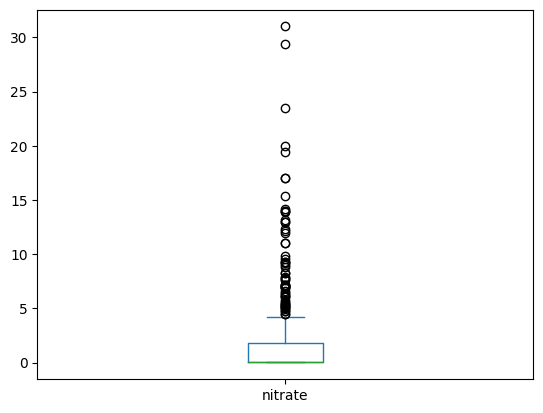

In [10]:
df[["nitrate"]].plot(kind = "box")

In [11]:
# top_nitrate_outliers = list(df["nitrate"].sort_values()[-3:].index)
# top_nitrate_outliers
# df = df.drop(top_nitrate_outliers)
# len(df)

## Test / train split

In [12]:
# Define the split by year
train_years = list(range(2008, 2021))
test_years = [2021]

# Filter datasets
train_df = df[df["year"].isin(train_years)].copy()
test_df = df[df["year"].isin(test_years)].copy()

print(f"Train: {len(train_df)}")
print(f"Test: {len(test_df)}")

Train: 305
Test: 34


In [13]:
# n = len(df)
# train_size = int(n * 0.8)

# train_df = df.iloc[:train_size]
# test_df = df.iloc[train_size:]

# print(f"Train: {len(train_df)}")
# print(f"Test: {len(test_df)}")

In [14]:
X_train = train_df.drop(columns=["nitrate", "bro-id", "date", "year", "geometry", "lon", "lat", "month"]).copy()
y_train = train_df["nitrate"]

X_test = test_df.drop(columns=["nitrate", "bro-id", "date", "year", "geometry", "lon", "lat", "month"]).copy()
y_test = test_df["nitrate"]

## Preprocess data

In [15]:
categorical_cols = X_train.select_dtypes(include="category").columns.tolist()
numerical_cols = X_train.select_dtypes(include=["float64", "int64"]).columns.tolist()

In [16]:
print("Categorical:", categorical_cols)
print("Numerical:", numerical_cols)
print("All X_train columns:", X_train.columns.tolist())

Categorical: ['mainsoilclassification_1']
Numerical: ['population', 'groundwater depth', 'elevation', 'precipitation', 'temperature', 'n deposition', 'organicmattercontent_1', 'density_1', 'acidity_1']
All X_train columns: ['population', 'groundwater depth', 'elevation', 'precipitation', 'temperature', 'n deposition', 'mainsoilclassification_1', 'organicmattercontent_1', 'density_1', 'acidity_1']


In [17]:
preprocessor = ColumnTransformer([
    ("cat_ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=False), categorical_cols),
    ("num_scaler", StandardScaler(), numerical_cols)
])

## Initialize model

In [18]:
xgb_reg = xgb.XGBRegressor(
    objective="reg:squarederror",
    n_jobs=-1,
    random_state=4
)

In [19]:
pipe = Pipeline([
    ("prep", preprocessor),
    ("xgb", xgb_reg)
])

full_pipeline = TransformedTargetRegressor(
    regressor=pipe,
    func=np.log1p,
    inverse_func=np.expm1
)

In [20]:
param_dist = {
    "regressor__xgb__n_estimators": [30, 50, 100],
    "regressor__xgb__max_depth": [5, 7, 8],
    "regressor__xgb__learning_rate": [0.05, 0.1, 0.15],
    "regressor__xgb__subsample": [0.6, 0.8, 1.0],
    "regressor__xgb__colsample_bytree": [0.3, 0.4, 0.6]
}

## Hyperparameter tuning

In [21]:
tscv = TimeSeriesSplit(n_splits=5)

search = RandomizedSearchCV(
    estimator=full_pipeline,
    param_distributions=param_dist,
    n_iter=60,
    cv=tscv,
    scoring=make_scorer(mean_absolute_error, greater_is_better=False), #"r2"
    verbose=1,
    random_state=9,
    n_jobs=-1
)

search.fit(X_train, y_train)
best_model = search.best_estimator_
best_params = search.best_params_

Fitting 5 folds for each of 60 candidates, totalling 300 fits


In [22]:
print("Best CV MAE:", -search.best_score_)
print("Best params:", search.best_params_)

Best CV MAE: 0.9671595961672068
Best params: {'regressor__xgb__subsample': 1.0, 'regressor__xgb__n_estimators': 30, 'regressor__xgb__max_depth': 7, 'regressor__xgb__learning_rate': 0.15, 'regressor__xgb__colsample_bytree': 0.6}


## Learning curve

In [23]:
train_sizes = np.linspace(0.1, 1.0, 10)
train_sizes

array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])

In [24]:
n = len(X_train)

train_errors = []
val_errors = []
train_stds = []
val_stds = []

for frac in train_sizes:
    split_idx = int(frac * n)
    X_subset = X_train.iloc[:split_idx]
    y_subset = y_train.iloc[:split_idx]

    tscv = TimeSeriesSplit(n_splits=5)
    fold_train_scores = []
    fold_val_scores = []

    for train_idx, val_idx in tscv.split(X_subset):
        X_tr, X_val = X_subset.iloc[train_idx], X_subset.iloc[val_idx]
        y_tr, y_val = y_subset.iloc[train_idx], y_subset.iloc[val_idx]

        model = clone(best_model)
        model.fit(X_tr, y_tr)

        y_tr_pred = model.predict(X_tr)
        y_val_pred = model.predict(X_val)

        fold_train_scores.append(mean_absolute_error(y_tr, y_tr_pred))
        fold_val_scores.append(mean_absolute_error(y_val, y_val_pred))

    # Store mean and std
    train_errors.append(np.mean(fold_train_scores))
    val_errors.append(np.mean(fold_val_scores))
    train_stds.append(np.std(fold_train_scores))
    val_stds.append(np.std(fold_val_scores))


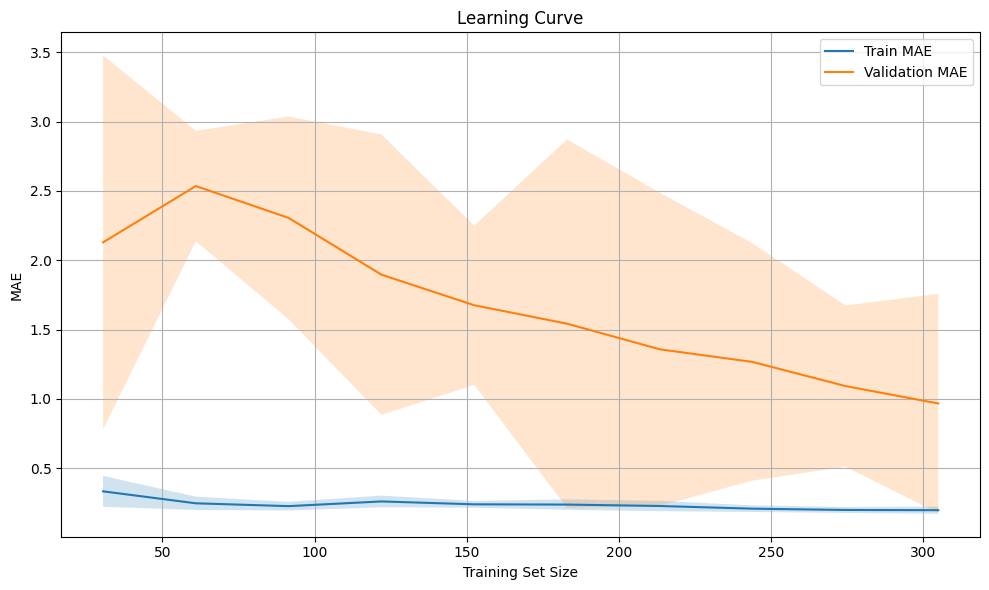

In [25]:
# X-axis
train_sizes_abs = train_sizes * len(X_train)

# Plot
plt.figure(figsize=(10, 6))
plt.plot(train_sizes_abs, train_errors, label="Train MAE")
plt.fill_between(train_sizes_abs, 
                 np.array(train_errors) - np.array(train_stds),
                 np.array(train_errors) + np.array(train_stds),
                 alpha=0.2)

plt.plot(train_sizes_abs, val_errors, label="Validation MAE")
plt.fill_between(train_sizes_abs, 
                 np.array(val_errors) - np.array(val_stds),
                 np.array(val_errors) + np.array(val_stds),
                 alpha=0.2)

plt.xlabel("Training Set Size")
plt.ylabel("MAE")
plt.title("Learning Curve")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Train model

In [26]:
best_model = clone(best_model)
best_model.fit(X_train, y_train)

TransformedTargetRegressor(func=<ufunc 'log1p'>, inverse_func=<ufunc 'expm1'>,
                           regressor=Pipeline(steps=[('prep',
                                                      ColumnTransformer(transformers=[('cat_ohe',
                                                                                       OneHotEncoder(handle_unknown='ignore',
                                                                                                     sparse_output=False),
                                                                                       ['mainsoilclassification_1']),
                                                                                      ('num_scaler',
                                                                                       StandardScaler(),
                                                                                       ['population',
                                                                                        'groundwater '
                                                                                        'depth',
                                                                                        'elevation',
                                                                                        'precipitation',
                                                                                        'temperature',
                                                                                        '...
                                                                   gamma=None,
                                                                   grow_policy=None,
                                                                   importance_type=None,
                                                                   interaction_constraints=None,
                                                                   learning_rate=0.15,
                                                                   max_bin=None,
                                                                   max_cat_threshold=None,
                                                                   max_cat_to_onehot=None,
                                                                   max_delta_step=None,
                                                                   max_depth=7,
                                                                   max_leaves=None,
                                                                   min_child_weight=None,
                                                                   missing=nan,
                                                                   monotone_constraints=None,
                                                                   multi_strategy=None,
                                                                   n_estimators=30,
                                                                   n_jobs=-1,
                                                                   num_parallel_tree=None,
                                                                   random_state=4, ...))]))

## Final Train score

In [27]:
pred_train = best_model.predict(X_train)

print("Train R2:", r2_score(y_train, pred_train))
print("Train MAE:", mean_absolute_error(y_train, pred_train))
print("Test RMSE:", sqrt(mean_squared_error(y_train, pred_train)))

Train R2: 0.9875143198910619
Train MAE: 0.15814003557328318
Test RMSE: 0.4981161388254099


## Final Test score

In [28]:
pred_nitrate = best_model.predict(X_test)

print("Test R2:", r2_score(y_test, pred_nitrate))
print("Test MAE:",mean_absolute_error(y_train, pred_train))
print("Test RMSE:", sqrt(mean_squared_error(y_test, pred_nitrate)))

Test R2: 0.6780576532102991
Test MAE: 0.15814003557328318
Test RMSE: 2.3720624407162854


In [29]:
pred_nitrate

array([ 2.138606  ,  0.05976333,  0.07362536,  0.08657337,  5.850861  ,
        0.9468473 ,  0.05704754,  0.08844616,  0.05979961,  0.06387311,
        1.9766479 ,  0.9058792 ,  0.31301525,  5.6201878 ,  0.5174499 ,
        0.15459375,  0.06730872,  0.15852787,  3.1722546 ,  6.118819  ,
        2.5372882 ,  0.28974688,  2.8276606 ,  0.43867588,  0.07994845,
        0.30103093,  0.7262538 ,  2.9142325 ,  1.525398  ,  0.11366686,
        0.06016805, 12.677556  ,  0.07503901,  0.05232885], dtype=float32)

## Real vs Predicted

<Axes: xlabel='nitrate', ylabel='nitrate'>

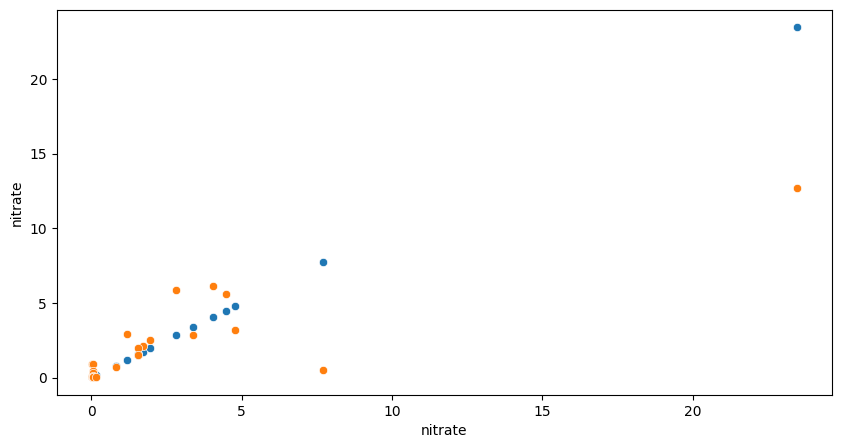

In [30]:
fix, ax = plt.subplots(figsize= (10,5))

sns.scatterplot(x = y_test, y = y_test, ax = ax)
sns.scatterplot(x = y_test, y = pred_nitrate, ax = ax)

Text(0, 0.5, 'Residuals')

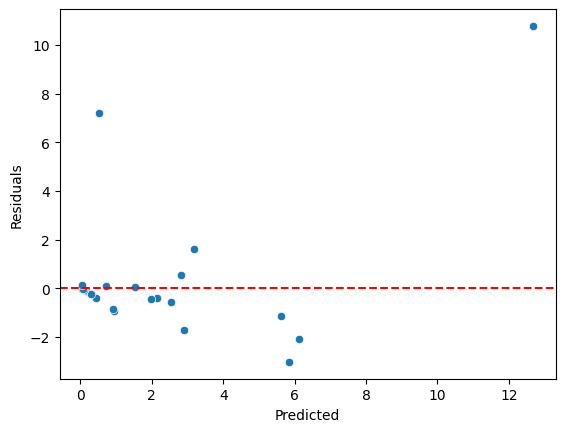

In [31]:
preds = best_model.predict(X_test)

residuals = y_test - preds
sns.scatterplot(x=preds, y=residuals)
plt.axhline(0, color="red", linestyle="--")
plt.xlabel("Predicted"); plt.ylabel("Residuals")

## Predictions on the map

In [32]:
coords = test_df[["lon", "lat"]].reset_index(drop=True)

print(len(coords['lon']))
print(len(coords['lat']))
print(len(np.expm1(pred_nitrate)))
print(len(np.expm1(y_test)))

34
34
34
34


In [33]:
#extract 'lon' and 'lat' from test_df
coords = test_df[["lon", "lat"]].reset_index(drop=True)

# construct new dataframe with predictions, real values and locations
gdf = gpd.GeoDataFrame({
    'lon': coords['lon'],
    'lat': coords['lat'],
    'nitrate_pred': pred_nitrate,
    'nitrate_true': y_test.reset_index(drop=True)
}, geometry=gpd.points_from_xy(coords["lon"], coords["lat"]))

gdf.crs = "EPSG:4326"

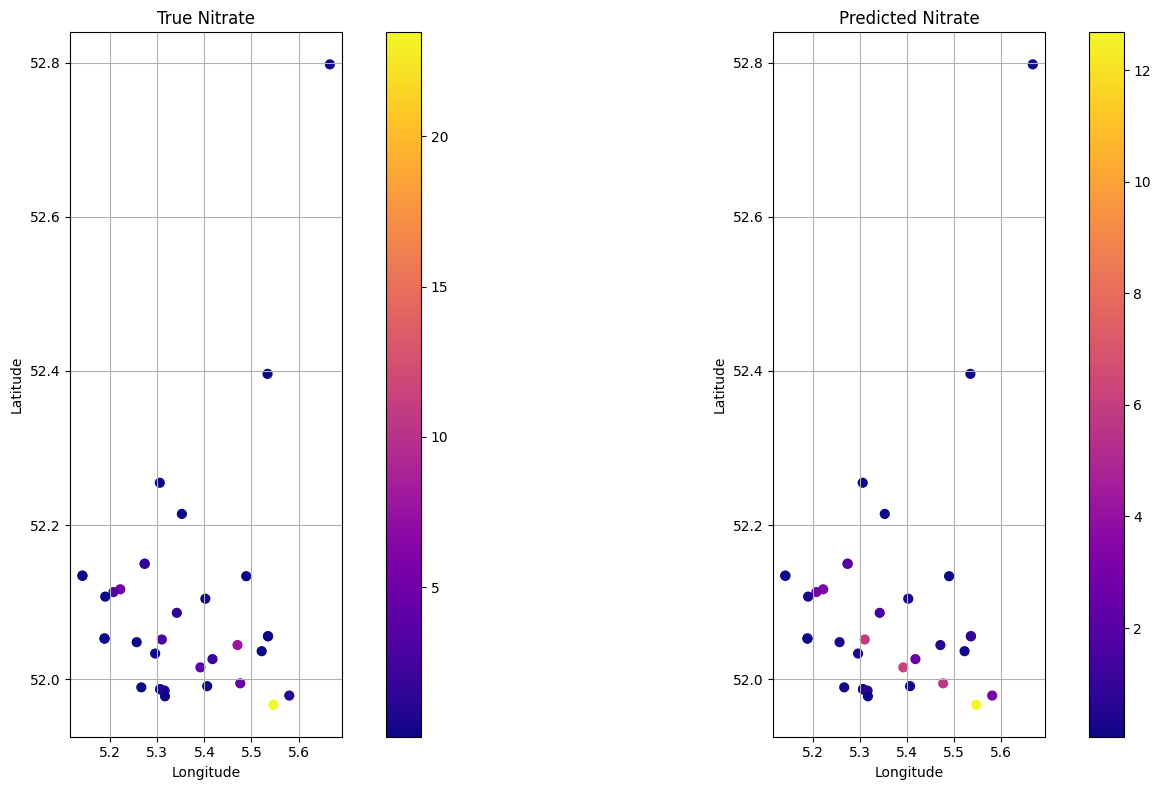

In [34]:
fig, axs = plt.subplots(1, 2, figsize=(16, 8))

gdf.plot(ax=axs[0], column="nitrate_true", cmap="plasma", legend=True, markersize=40)
axs[0].set_title("True Nitrate")

gdf.plot(ax=axs[1], column="nitrate_pred", cmap="plasma", legend=True, markersize=40)
axs[1].set_title("Predicted Nitrate")

for ax in axs:
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    ax.grid(True)

plt.tight_layout()
plt.show()

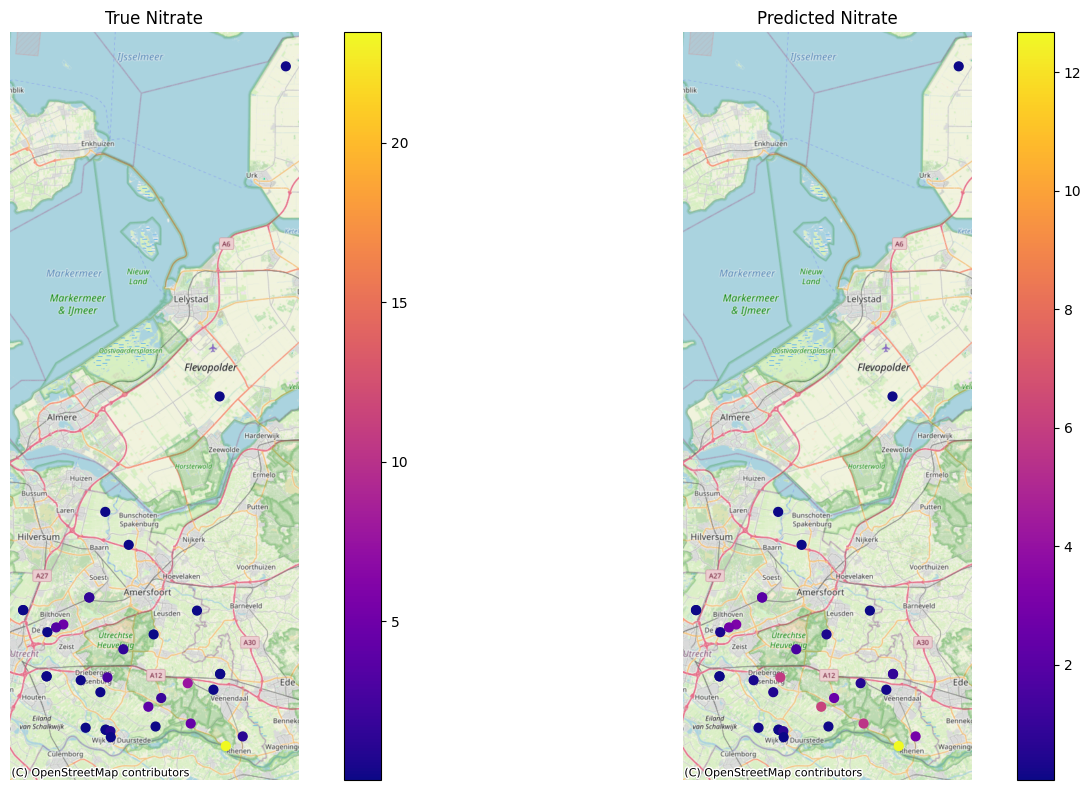

In [35]:
gdf_3857 = gdf.to_crs(epsg=3857)

fig, axs = plt.subplots(1, 2, figsize=(16, 8))

gdf_3857.plot(ax=axs[0], column="nitrate_true", cmap="plasma", legend=True, markersize=40)
ctx.add_basemap(axs[0], source=ctx.providers.OpenStreetMap.Mapnik)
axs[0].set_title("True Nitrate")

gdf_3857.plot(ax=axs[1], column="nitrate_pred", cmap="plasma", legend=True, markersize=40)
ctx.add_basemap(axs[1], source=ctx.providers.OpenStreetMap.Mapnik)
axs[1].set_title("Predicted Nitrate")

for ax in axs:
    ax.set_axis_off()

plt.tight_layout()
plt.show()

## Interpretability

In [36]:
best_model = clone(best_model)
best_model.fit(X_train, y_train)

TransformedTargetRegressor(func=<ufunc 'log1p'>, inverse_func=<ufunc 'expm1'>,
                           regressor=Pipeline(steps=[('prep',
                                                      ColumnTransformer(transformers=[('cat_ohe',
                                                                                       OneHotEncoder(handle_unknown='ignore',
                                                                                                     sparse_output=False),
                                                                                       ['mainsoilclassification_1']),
                                                                                      ('num_scaler',
                                                                                       StandardScaler(),
                                                                                       ['population',
                                                                                        'groundwater '
                                                                                        'depth',
                                                                                        'elevation',
                                                                                        'precipitation',
                                                                                        'temperature',
                                                                                        '...
                                                                   gamma=None,
                                                                   grow_policy=None,
                                                                   importance_type=None,
                                                                   interaction_constraints=None,
                                                                   learning_rate=0.15,
                                                                   max_bin=None,
                                                                   max_cat_threshold=None,
                                                                   max_cat_to_onehot=None,
                                                                   max_delta_step=None,
                                                                   max_depth=7,
                                                                   max_leaves=None,
                                                                   min_child_weight=None,
                                                                   missing=nan,
                                                                   monotone_constraints=None,
                                                                   multi_strategy=None,
                                                                   n_estimators=30,
                                                                   n_jobs=-1,
                                                                   num_parallel_tree=None,
                                                                   random_state=4, ...))]))

In [37]:
if isinstance(best_model, TransformedTargetRegressor):
    print("Yes, this is a TransformedTargetRegressor.")
else:
    print("Nope, it's not.")

Yes, this is a TransformedTargetRegressor.


In [38]:
inner_pipeline = best_model.regressor_
fitted_preprocessor = inner_pipeline.named_steps['prep']
fitted_model = inner_pipeline.named_steps['xgb']

feature_names = fitted_preprocessor.get_feature_names_out()

### Default interpretability: Gain

In [39]:
importances = fitted_model.feature_importances_

importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values(by='importance', ascending=False)

print(importance_df)

                                              feature  importance
16                              num_scaler__acidity_1    0.342904
10                              num_scaler__elevation    0.181273
15                              num_scaler__density_1    0.128002
14                 num_scaler__organicmattercontent_1    0.105913
4     cat_ohe__mainsoilclassification_1_Podzolgronden    0.066777
7    cat_ohe__mainsoilclassification_1_Zeekleigronden    0.064175
0   cat_ohe__mainsoilclassification_1_Dikke eerdgr...    0.035582
8                              num_scaler__population    0.019289
9                       num_scaler__groundwater depth    0.013980
3   cat_ohe__mainsoilclassification_1_Moerige gronden    0.012712
13                           num_scaler__n deposition    0.008917
2   cat_ohe__mainsoilclassification_1_Kalkloze zan...    0.007371
12                            num_scaler__temperature    0.005381
5   cat_ohe__mainsoilclassification_1_Rivierkleigr...    0.004762
11        

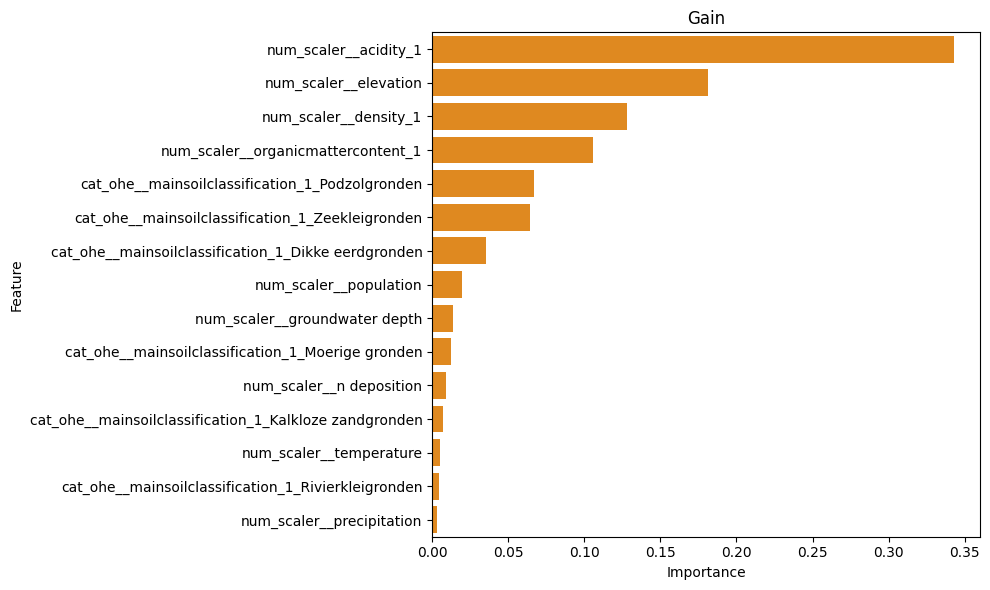

In [40]:
fi_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": importances
}).sort_values("Importance", ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x="Importance", y="Feature", data=fi_df.head(15), color="darkorange")
plt.title("Gain")
plt.tight_layout()
plt.show()

In [41]:
booster = fitted_model.get_booster()

feature_map = {f"f{i}": name for i, name in enumerate(feature_names)}

importance_types = ["gain", "cover", "weight"]
# importance_types = ["gain"]
importance_data = []

for imp_type in importance_types:
    imp_dict = booster.get_score(importance_type=imp_type)
    for fx, val in imp_dict.items():
        importance_data.append({
            "Feature": feature_map.get(fx, fx), #here we map f1, f2, etc with real feature names
            "Importance": val,
            "Type": imp_type
        })

In [42]:
# convert list of dictionaries to pandas df
importances_df = pd.DataFrame(importance_data)

# normalize the feature importances within each importance type
# divide every value in that group by the total sum of the group
# so it always ranges between (0 - 1)
importances_df["Importance"] = importances_df.groupby("Type")["Importance"].transform(lambda x: x / x.sum())

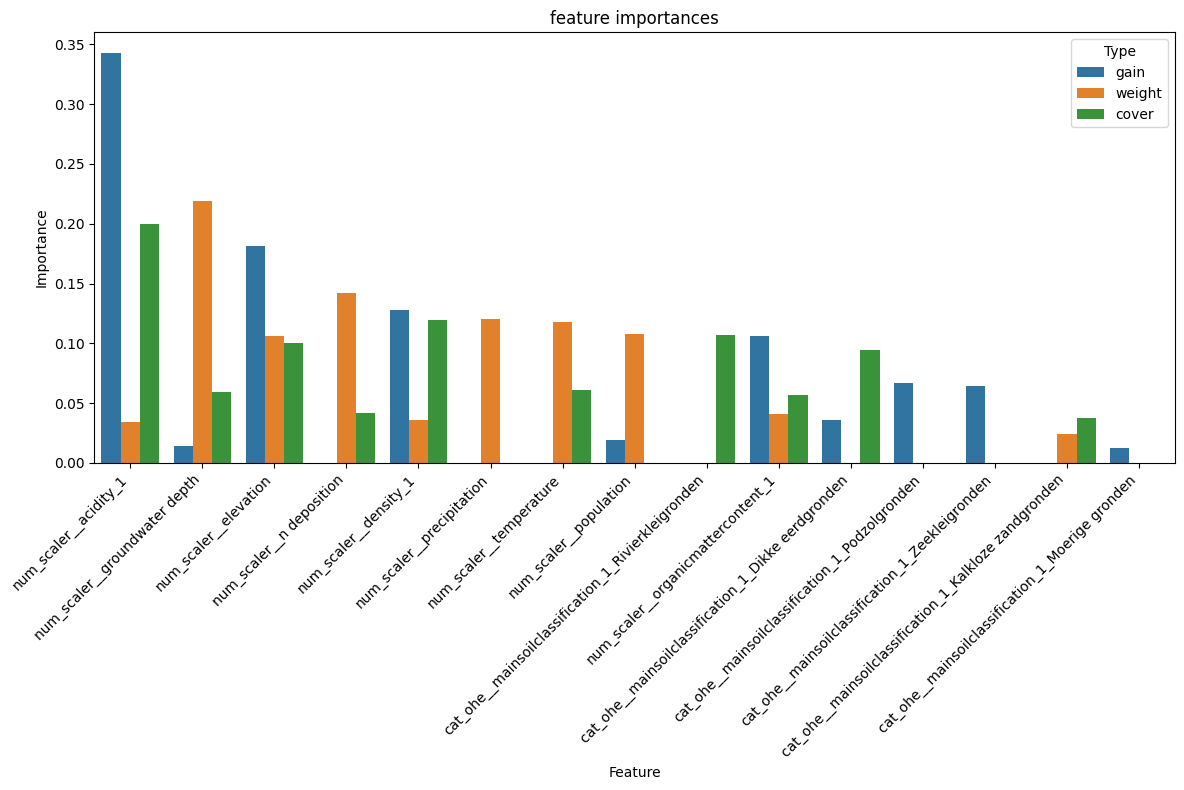

In [43]:
plt.figure(figsize=(12, 8))
sns.barplot(
    data=importances_df.sort_values("Importance", ascending=False).groupby("Type").head(10),
    x="Feature",
    y="Importance",
    hue="Type"
)
plt.xticks(rotation=45, ha='right')
plt.title("feature importances")
plt.tight_layout()
plt.show()


# Model-agnostic interpretability

In [44]:
assert fitted_model.n_features_in_ == len(feature_names)

In [45]:
# Transform X_test using preprocessor
X_test_transformed = fitted_preprocessor.transform(X_test)
y_test_true = y_test

## Permutation

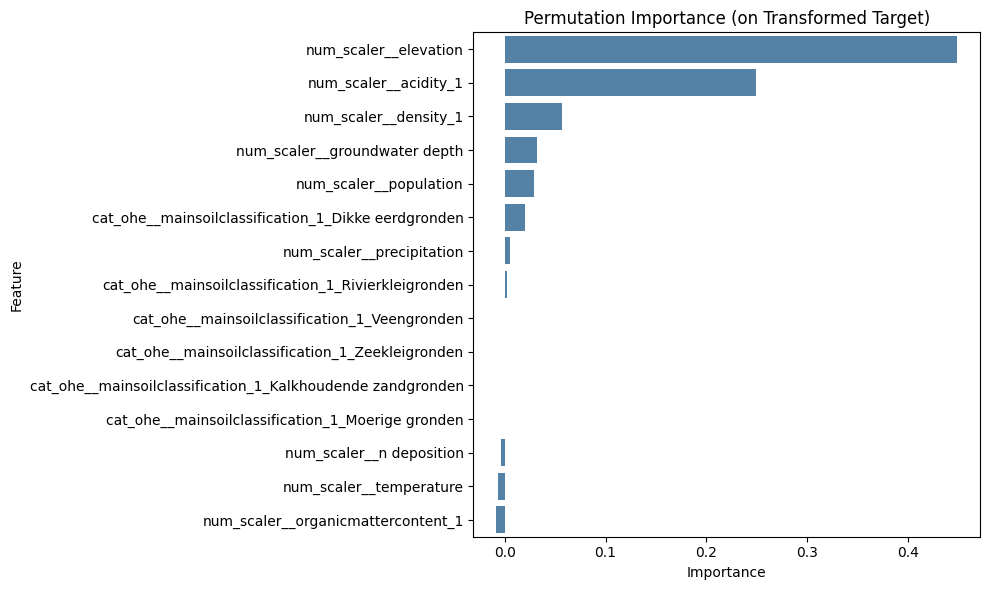

In [46]:
# If your target was transformed using log1p, reverse it before comparing
if isinstance(best_model, TransformedTargetRegressor):
    y_test_true = np.log1p(y_test)

# Run permutation importance
perm_result = permutation_importance(
    fitted_model, 
    X_test_transformed, 
    y_test_true,
    n_repeats=10,
    random_state=42,
    scoring="r2"
)

perm_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": perm_result.importances_mean,
    "Std": perm_result.importances_std
}).sort_values("Importance", ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x="Importance", y="Feature", data=perm_df.head(15), color="steelblue")
plt.title("Permutation Importance (on Transformed Target)")
plt.tight_layout()
plt.show()


In [47]:
perm_df["Importance"] /= perm_df["Importance"].sum()
perm_df["Type"] = "permutation"

combined_df = pd.concat([importances_df, perm_df], axis=0)

In [48]:
combined_df

,Feature,Importance,Type,Std
0,cat_ohe__mainsoilclassification_1_Dikke eerdgr...,0.035582,gain,NaN
1,cat_ohe__mainsoilclassification_1_Kalkloze zan...,0.007371,gain,NaN
2,cat_ohe__mainsoilclassification_1_Moerige gronden,0.012712,gain,NaN
3,cat_ohe__mainsoilclassification_1_Podzolgronden,0.066777,gain,NaN
4,cat_ohe__mainsoilclassification_1_Rivierkleigr...,0.004762,gain,NaN
...,...,...,...,...
13,num_scaler__n deposition,-0.005479,permutation,0.013103
12,num_scaler__temperature,-0.008891,permutation,0.002688
14,num_scaler__organicmattercontent_1,-0.011673,permutation,0.048121
2,cat_ohe__mainsoilclassification_1_Kalkloze zan...,-0.059675,permutation,0.025454


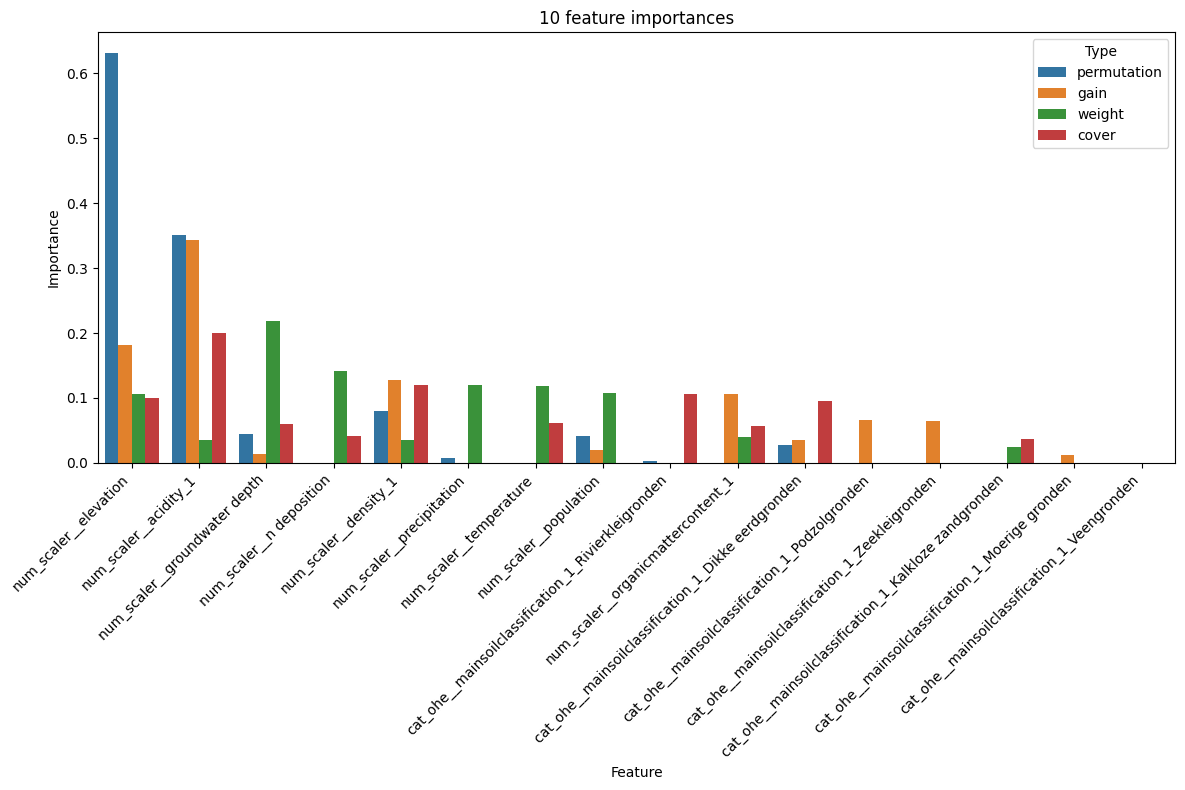

In [49]:
plt.figure(figsize=(12, 8))
sns.barplot(
    data=combined_df.sort_values("Importance", ascending=False).groupby("Type").head(10),
    x="Feature",
    y="Importance",
    hue="Type"
)
plt.xticks(rotation=45, ha='right')
plt.title("10 feature importances")
plt.tight_layout()
plt.show()

## Tree SHAP

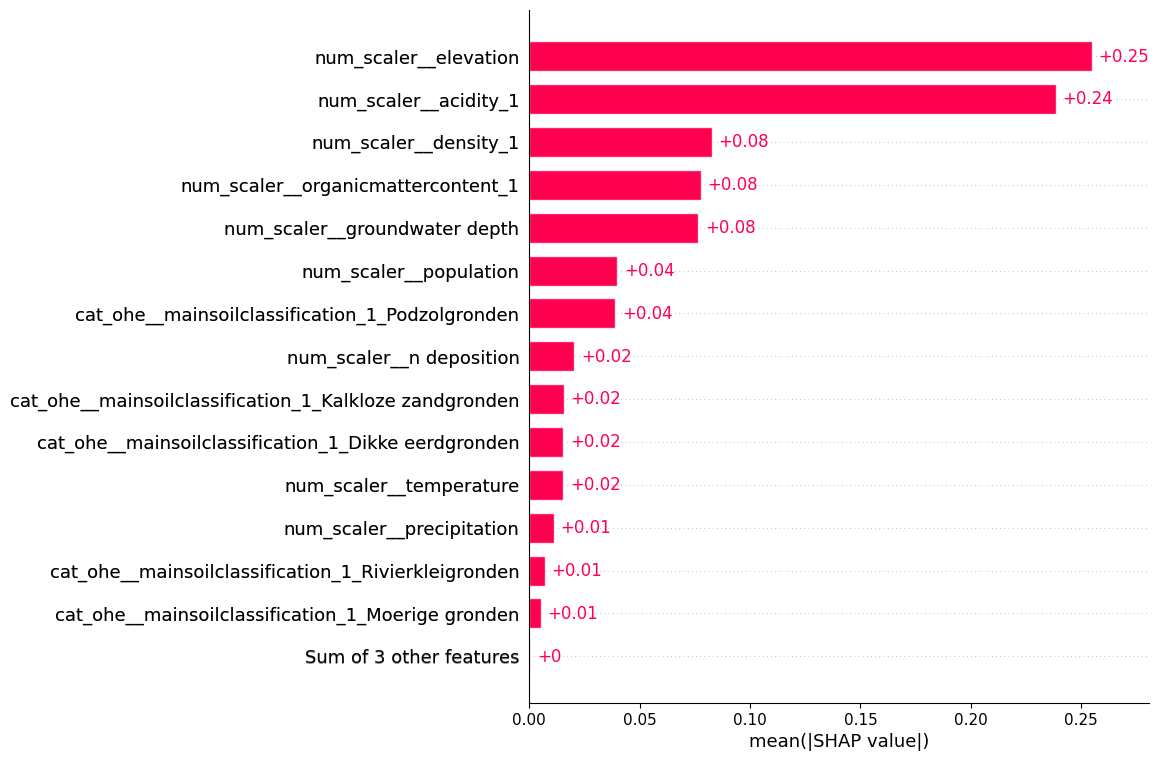

In [50]:
X_test_transformed = fitted_preprocessor.transform(X_test)
X_test_transformed_df = pd.DataFrame(X_test_transformed, columns=feature_names)

explainer = shap.TreeExplainer(fitted_model)

shap_values = explainer(X_test_transformed)

shap_explanation = shap.Explanation(
    values=shap_values,
    base_values=explainer.expected_value,
    data=X_test_transformed_df.values,
    feature_names=X_test_transformed_df.columns
)

shap.plots.bar(shap_explanation, max_display=15)


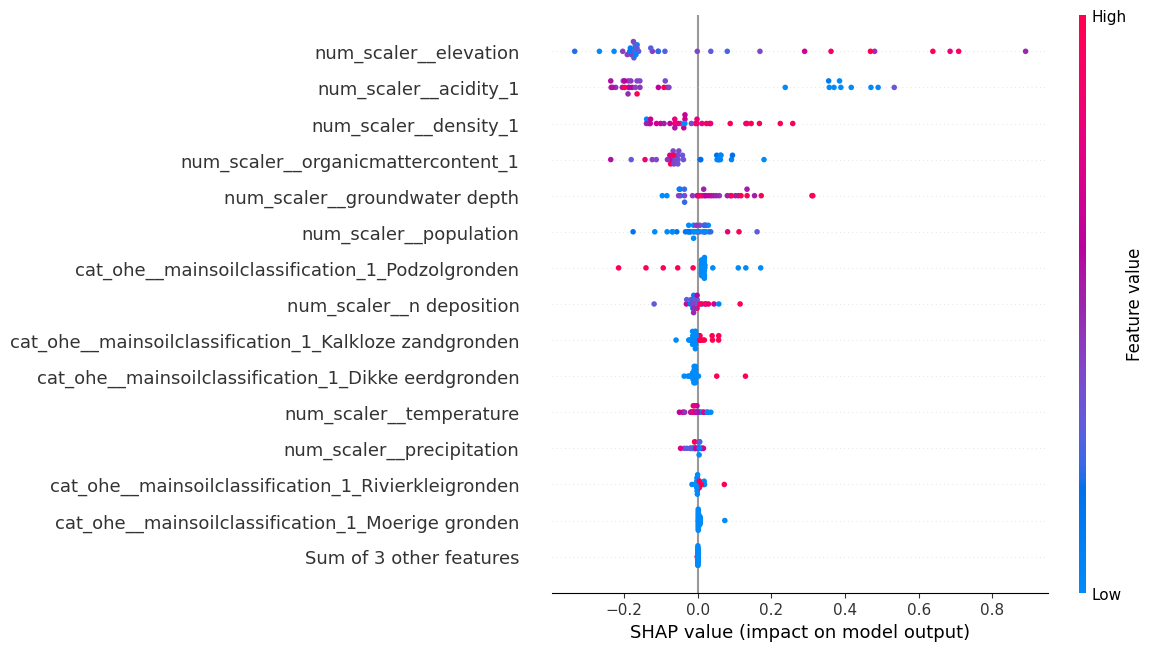

In [51]:
shap.plots.beeswarm(shap_explanation, max_display=15)

In [52]:
shap_mean_importance = np.abs(shap_values.values).mean(axis=0)
shap_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": shap_mean_importance
}).sort_values("Importance", ascending=False)

shap_df["Importance"] /= shap_df["Importance"].sum()
shap_df["Type"] = "shap"


In [53]:
perm_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": perm_result.importances_mean
}).sort_values("Importance", ascending=False)

perm_df["Importance"] /= perm_df["Importance"].sum()
perm_df["Type"] = "permutation"


In [54]:
from lime.lime_tabular import LimeTabularExplainer

lime_explainer = LimeTabularExplainer(
    X_test_transformed_df.values,
    feature_names=feature_names,
    mode='regression',
    random_state=42
)

lime_weights = np.zeros(len(feature_names))
n_samples = 30

for i in range(n_samples):
    explanation = lime_explainer.explain_instance(
        X_test_transformed_df.values[i],
        fitted_model.predict,
        num_features=len(feature_names)
    )
    
    for feature_str, weight in explanation.as_list():
        # Match by checking which real feature name is included in LIME's string
        for j, fname in enumerate(feature_names):
            if fname in feature_str:
                lime_weights[j] += abs(weight)
                break  # stop at first match


lime_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": lime_weights / lime_weights.sum(),
    "Type": "lime"
})

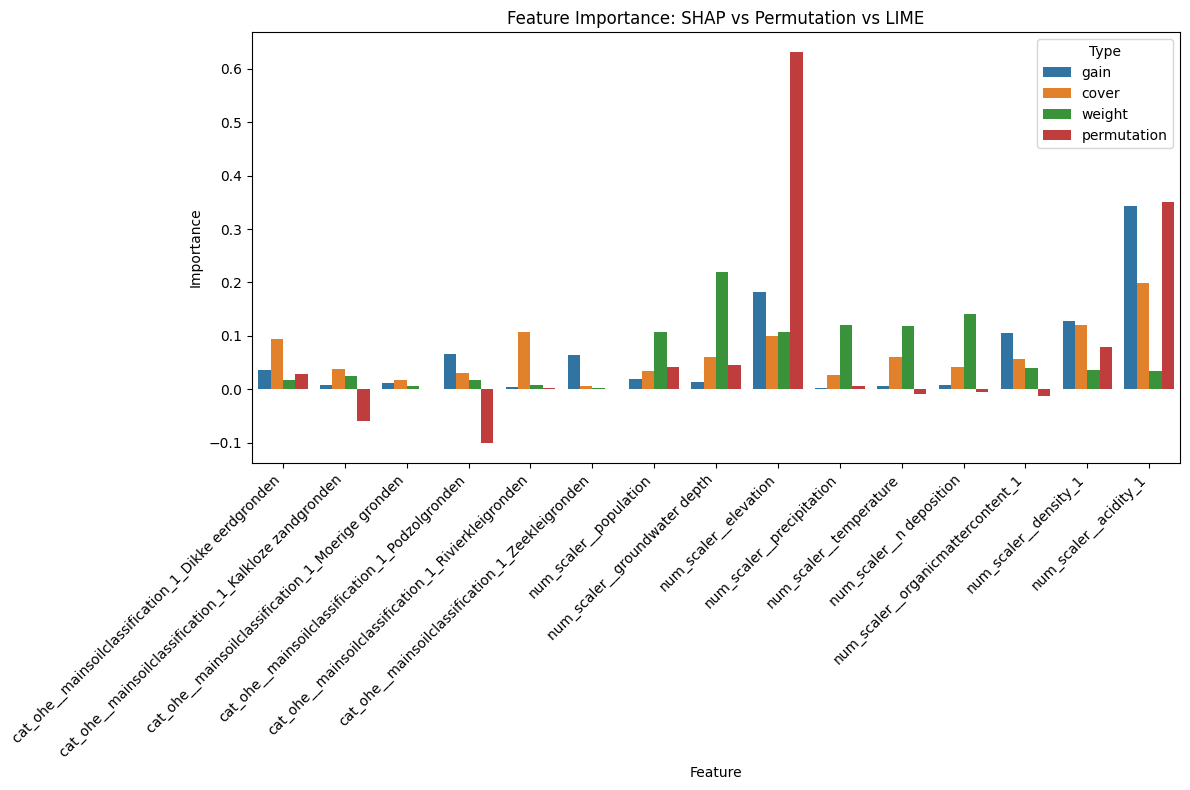

In [55]:
plt.figure(figsize=(12, 8))
sns.barplot(
    data=combined_df[combined_df["Feature"].isin(
        combined_df.groupby("Feature")["Importance"].sum().nlargest(15).index
    )],
    x="Feature", y="Importance", hue="Type"
)
plt.xticks(rotation=45, ha="right")  # rotate labels for readability
plt.title("Feature Importance: SHAP vs Permutation vs LIME")
plt.tight_layout()
plt.show()
